In [16]:
import pandas as pd
import numpy as np

import optuna
from optuna.samplers import TPESampler

import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# =========================
# Utils
# =========================
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def find_roll4_col(df, target_name: str):
    cols = list(df.columns)
    lower = {c: c.lower() for c in cols}

    # exact common patterns
    exact = []
    for c in cols:
        cl = lower[c]
        if cl == f"roll4_{target_name}".lower() or cl == f"{target_name}_roll4".lower():
            exact.append(c)
    if len(exact) == 1:
        return exact[0]
    if len(exact) > 1:
        raise ValueError(f"Multiple exact roll4 columns found for {target_name}: {exact}")

    # fallback: contains both
    cand = [c for c in cols if ("roll4" in lower[c]) and (target_name.lower() in lower[c])]
    if len(cand) == 1:
        return cand[0]
    if len(cand) == 0:
        raise ValueError(f"No roll4 column found for target={target_name}.")
    raise ValueError(f"Multiple candidate roll4 columns found for {target_name}: {cand}")

# =========================
# 1) Load
# =========================
path = "../../final_data/data_260125_random.csv"
df = pd.read_csv(path)
df["experiment_date"] = pd.to_datetime(df["experiment_date"])

TEST_WEEK = pd.Timestamp("2026-01-05")
VAL_WEEKS = 4
N_TRIALS = 60  # 先跑 30~60 試試，覺得穩再加大

# =========================
# 2) Define columns
# =========================
id_cols = ["experiment_date", "treatment", "source", "ops_type_merged", "city_group"]
target_cols = ["nonrepeat_cnt_per_user", "trip_cnt_per_user"]

# 你原本指定的連續/數值特徵
base_cols = [
    "face_value",
    "face_value_num",
    "avg_rainy_day",
    "avg_rainy_weekday",
    "avg_rainy_weekend",
    "mgm_day",
    "delta_trip_per_user",
    "delta_nonrepeat_per_user",
    "ratio_trip_per_user",
    "ratio_nonrepeat_per_user",
]

# 其他 roll4 特徵
roll4_cols = [c for c in df.columns if "roll4" in c.lower()]

# 這次要放進模型的 categorical 欄位（原本在 id_cols 裡）
cat_extra = ["treatment", "source", "ops_type_merged", "city_group"]

feature_cols = base_cols + roll4_cols + cat_extra

need_cols = ["experiment_date"] + target_cols + feature_cols  # train/val/test 需要
missing = [c for c in need_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

# =========================
# 3) Split: train / val / test (time-based)
# =========================
all_weeks = (
    df.loc[df["experiment_date"] < TEST_WEEK, "experiment_date"]
      .dropna()
      .drop_duplicates()
      .sort_values()
      .to_list()
)
if len(all_weeks) < VAL_WEEKS:
    raise ValueError(f"Not enough weeks before TEST_WEEK to make {VAL_WEEKS} validation weeks.")

val_weeks = set(all_weeks[-VAL_WEEKS:])
train_weeks = set(all_weeks[:-VAL_WEEKS])

train_df = df.loc[df["experiment_date"].isin(train_weeks), need_cols].copy()
val_df   = df.loc[df["experiment_date"].isin(val_weeks), need_cols].copy()
test_df  = df.loc[df["experiment_date"] == TEST_WEEK, need_cols].copy()

if len(test_df) == 0:
    raise ValueError("No rows found for experiment_date == 2026-01-05")

print("VAL weeks:", sorted(list(val_weeks)))
print("Train rows:", len(train_df), "Val rows:", len(val_df), "Test rows:", len(test_df))

# =========================
# 4) Build X / y  + one-hot categorical
# =========================
X_train = train_df[feature_cols].copy()
X_val   = val_df[feature_cols].copy()
X_test  = test_df[feature_cols].copy()

y_train_nonrepeat = train_df["nonrepeat_cnt_per_user"].astype(float)
y_val_nonrepeat   = val_df["nonrepeat_cnt_per_user"].astype(float)
y_test_nonrepeat  = test_df["nonrepeat_cnt_per_user"].astype(float)

y_train_trip = train_df["trip_cnt_per_user"].astype(float)
y_val_trip   = val_df["trip_cnt_per_user"].astype(float)
y_test_trip  = test_df["trip_cnt_per_user"].astype(float)

cat_cols = cat_extra
#cat_cols = ["face_value"] + cat_extra


for X in (X_train, X_val, X_test):
    for c in cat_cols:
        X[c] = X[c].astype("category")

# one-hot（最穩的作法；也避免版本差異）
X_train = pd.get_dummies(X_train, columns=cat_cols, dummy_na=True)
X_val   = pd.get_dummies(X_val,   columns=cat_cols, dummy_na=True)
X_test  = pd.get_dummies(X_test,  columns=cat_cols, dummy_na=True)

# 對齊欄位（dummy 欄位 train/val/test 可能不一致）
X_train, X_val = X_train.align(X_val, join="left", axis=1, fill_value=0)
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

# =========================
# 5) Optuna objective (tune on VAL RMSE)
# =========================
def make_objective(y_tr, y_va):
    def objective(trial: optuna.Trial):
        params = {
            # 固定
            "n_estimators": 20000,  # 讓 early stopping 決定 best iteration
            "random_state": 42,
            "n_jobs": -1,
            "verbose": -1,

            # 調參範圍（你可依需求縮小/放大）
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.08, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 15, 255, log=True),
            "max_depth": trial.suggest_int("max_depth", -1, 16),
            "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
            "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
        }

        model = LGBMRegressor(**params)
        model.fit(
            X_train, y_tr,
            eval_set=[(X_val, y_va)],
            eval_metric="rmse",
            callbacks=[
                lgb.early_stopping(stopping_rounds=200, verbose=False),
                lgb.log_evaluation(period=0),
            ],
        )

        pred_val = model.predict(X_val)
        return rmse(y_va, pred_val)

    return objective

# =========================
# 6) Run studies (one per target)
# =========================
sampler = TPESampler(seed=42)

# nonrepeat
study_nonrepeat = optuna.create_study(direction="minimize", sampler=sampler)
study_nonrepeat.optimize(make_objective(y_train_nonrepeat, y_val_nonrepeat), n_trials=N_TRIALS)

print("\n[Best nonrepeat]")
print("val_rmse:", study_nonrepeat.best_value)
print("params:", study_nonrepeat.best_params)

# trip
study_trip = optuna.create_study(direction="minimize", sampler=sampler)
study_trip.optimize(make_objective(y_train_trip, y_val_trip), n_trials=N_TRIALS)

print("\n[Best trip]")
print("val_rmse:", study_trip.best_value)
print("params:", study_trip.best_params)

# =========================
# 7) Retrain on train+val with best params, then test on 2026-01-05
# =========================
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval_nonrepeat = pd.concat([y_train_nonrepeat, y_val_nonrepeat], axis=0)
y_trainval_trip = pd.concat([y_train_trip, y_val_trip], axis=0)

def fit_best(best_params, X_tr, y_tr):
    final_params = {
        "n_estimators": 20000,
        "random_state": 42,
        "n_jobs": -1,
        "verbose": -1,
        **best_params,
    }
    model = LGBMRegressor(**final_params)
    model.fit(X_tr, y_tr)
    return model

m_nonrepeat = fit_best(study_nonrepeat.best_params, X_trainval, y_trainval_nonrepeat)
m_trip      = fit_best(study_trip.best_params,      X_trainval, y_trainval_trip)

pred_nonrepeat = m_nonrepeat.predict(X_test)
pred_trip      = m_trip.predict(X_test)

# =========================
# 8) Evaluate + keep pred vs true
# =========================
eval_df = test_df[id_cols + target_cols].copy()
eval_df["pred_nonrepeat_cnt_per_user"] = pred_nonrepeat
eval_df["pred_trip_cnt_per_user"] = pred_trip
eval_df["err_nonrepeat"] = eval_df["pred_nonrepeat_cnt_per_user"] - eval_df["nonrepeat_cnt_per_user"]
eval_df["err_trip"] = eval_df["pred_trip_cnt_per_user"] - eval_df["trip_cnt_per_user"]

print("\n[Test RMSE on 2026-01-05]")
print("RMSE (nonrepeat):", rmse(y_test_nonrepeat, pred_nonrepeat))
print("RMSE (trip)     :", rmse(y_test_trip, pred_trip))

# =========================
# 9) (Optional) Compare roll4 baseline on same test week
# =========================
col_roll4_nonrepeat = find_roll4_col(df, "nonrepeat_cnt_per_user")
col_roll4_trip = find_roll4_col(df, "trip_cnt_per_user")

baseline_nonrepeat = test_df[col_roll4_nonrepeat].astype(float).values
baseline_trip = test_df[col_roll4_trip].astype(float).values

print("\n[Roll4 baseline RMSE on 2026-01-05]")
print("baseline RMSE (nonrepeat):", rmse(y_test_nonrepeat, baseline_nonrepeat))
print("baseline RMSE (trip)     :", rmse(y_test_trip, baseline_trip))

# （需要就存）
# eval_df.to_csv("../../final_data/pred_eval_2026-01-05_optuna_with_cats.csv", index=False, encoding="utf-8-sig")


[I 2026-01-26 22:53:29,935] A new study created in memory with name: no-name-aa541cbb-0d95-45eb-8754-b0bc63d876fe
[I 2026-01-26 22:53:30,112] Trial 0 finished with value: 0.08420457278675528 and parameters: {'learning_rate': 0.014124115025060347, 'num_leaves': 222, 'max_depth': 12, 'min_child_samples': 124, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469887, 'min_split_gain': 0.6011150117432088}. Best is trial 0 with value: 0.08420457278675528.


VAL weeks: [Timestamp('2025-12-08 00:00:00'), Timestamp('2025-12-15 00:00:00'), Timestamp('2025-12-22 00:00:00'), Timestamp('2025-12-29 00:00:00')]
Train rows: 1344 Val rows: 768 Test rows: 192


[I 2026-01-26 22:53:30,227] Trial 1 finished with value: 0.08143021792830588 and parameters: {'learning_rate': 0.03561019439085494, 'num_leaves': 15, 'max_depth': 16, 'min_child_samples': 168, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'reg_alpha': 4.4734294104626844e-07, 'reg_lambda': 5.472429642032189e-06, 'min_split_gain': 0.5247564316322378}. Best is trial 1 with value: 0.08143021792830588.
[I 2026-01-26 22:53:30,453] Trial 2 finished with value: 0.07240571079479077 and parameters: {'learning_rate': 0.016560888480945335, 'num_leaves': 33, 'max_depth': 10, 'min_child_samples': 36, 'subsample': 0.6460723242676091, 'colsample_bytree': 0.6831809216468459, 'reg_alpha': 0.00012724181576752517, 'reg_lambda': 0.11656915613247415, 'min_split_gain': 0.19967378215835974}. Best is trial 2 with value: 0.07240571079479077.
[I 2026-01-26 22:53:30,566] Trial 3 finished with value: 0.09476705979880147 and parameters: {'learning_rate': 0.02080510765641852, 'num_leaves':


[Best nonrepeat]
val_rmse: 0.062009377295977004
params: {'learning_rate': 0.06287019201827068, 'num_leaves': 50, 'max_depth': 2, 'min_child_samples': 30, 'subsample': 0.8159104694505545, 'colsample_bytree': 0.6096546357452857, 'reg_alpha': 0.00796169381359022, 'reg_lambda': 0.0018599558583959036, 'min_split_gain': 0.0024140505747444075}


[I 2026-01-26 22:53:42,844] Trial 0 finished with value: 0.04906059426420502 and parameters: {'learning_rate': 0.006965877385711506, 'num_leaves': 112, 'max_depth': 12, 'min_child_samples': 117, 'subsample': 0.8854835899772805, 'colsample_bytree': 0.7468977981821954, 'reg_alpha': 0.0005065186776865479, 'reg_lambda': 7.04480806377519e-05, 'min_split_gain': 0.02541912674409519}. Best is trial 0 with value: 0.04906059426420502.
[I 2026-01-26 22:53:42,988] Trial 1 finished with value: 0.06727399875359648 and parameters: {'learning_rate': 0.00674348238712931, 'num_leaves': 16, 'max_depth': 10, 'min_child_samples': 70, 'subsample': 0.7542853455823514, 'colsample_bytree': 0.9537832369630466, 'reg_alpha': 1.7523871598466864e-06, 'reg_lambda': 4.9368087974032924e-05, 'min_split_gain': 0.7555511385430487}. Best is trial 0 with value: 0.04906059426420502.
[I 2026-01-26 22:53:43,117] Trial 2 finished with value: 0.06755056186355944 and parameters: {'learning_rate': 0.009429104466938067, 'num_leave


[Best trip]
val_rmse: 0.048519147914630106
params: {'learning_rate': 0.011589076449767368, 'num_leaves': 56, 'max_depth': 14, 'min_child_samples': 33, 'subsample': 0.8748052366626635, 'colsample_bytree': 0.7633220251320807, 'reg_alpha': 0.04731682334671361, 'reg_lambda': 0.0036755558258702785, 'min_split_gain': 0.009488994980868389}

[Test RMSE on 2026-01-05]
RMSE (nonrepeat): 0.05011517965230405
RMSE (trip)     : 0.03714980810158967

[Roll4 baseline RMSE on 2026-01-05]
baseline RMSE (nonrepeat): 0.06620423571105885
baseline RMSE (trip)     : 0.045439844094986394


[I 2026-01-26 22:54:13,325] A new study created in memory with name: no-name-20f375fb-79ab-48fa-8e20-b509b6f5a5ee


VAL weeks: [Timestamp('2025-12-08 00:00:00'), Timestamp('2025-12-15 00:00:00'), Timestamp('2025-12-22 00:00:00'), Timestamp('2025-12-29 00:00:00')]
Train rows: 1344 Val rows: 768 Test rows: 192


[I 2026-01-26 22:54:13,498] Trial 0 finished with value: 0.08468731605953927 and parameters: {'learning_rate': 0.014124115025060347, 'num_leaves': 222, 'max_depth': 12, 'min_child_samples': 124, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469887, 'min_split_gain': 0.6011150117432088}. Best is trial 0 with value: 0.08468731605953927.
[I 2026-01-26 22:54:13,618] Trial 1 finished with value: 0.08163081002443694 and parameters: {'learning_rate': 0.03561019439085494, 'num_leaves': 15, 'max_depth': 16, 'min_child_samples': 168, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'reg_alpha': 4.4734294104626844e-07, 'reg_lambda': 5.472429642032189e-06, 'min_split_gain': 0.5247564316322378}. Best is trial 1 with value: 0.08163081002443694.
[I 2026-01-26 22:54:13,841] Trial 2 finished with value: 0.07254346451509647 and parameters: {'learning_rate': 0.016560888480945335, 'num_leaves'


[Best nonrepeat]
val_rmse: 0.06181228783823427
params: {'learning_rate': 0.05439777977477132, 'num_leaves': 162, 'max_depth': 4, 'min_child_samples': 46, 'subsample': 0.9151086582218799, 'colsample_bytree': 0.8878008475000606, 'reg_alpha': 0.0031967949016467475, 'reg_lambda': 0.06931764709856013, 'min_split_gain': 0.0002554939925021868}


[I 2026-01-26 22:58:39,839] Trial 0 finished with value: 0.04915135076659245 and parameters: {'learning_rate': 0.006965877385711506, 'num_leaves': 112, 'max_depth': 12, 'min_child_samples': 117, 'subsample': 0.8854835899772805, 'colsample_bytree': 0.7468977981821954, 'reg_alpha': 0.0005065186776865479, 'reg_lambda': 7.04480806377519e-05, 'min_split_gain': 0.02541912674409519}. Best is trial 0 with value: 0.04915135076659245.
[I 2026-01-26 22:58:40,014] Trial 1 finished with value: 0.06727399875359648 and parameters: {'learning_rate': 0.00674348238712931, 'num_leaves': 16, 'max_depth': 10, 'min_child_samples': 70, 'subsample': 0.7542853455823514, 'colsample_bytree': 0.9537832369630466, 'reg_alpha': 1.7523871598466864e-06, 'reg_lambda': 4.9368087974032924e-05, 'min_split_gain': 0.7555511385430487}. Best is trial 0 with value: 0.04915135076659245.
[I 2026-01-26 22:58:40,168] Trial 2 finished with value: 0.06755056186355944 and parameters: {'learning_rate': 0.009429104466938067, 'num_leave


[Best trip]
val_rmse: 0.047648439214972985
params: {'learning_rate': 0.0737991883498914, 'num_leaves': 22, 'max_depth': 4, 'min_child_samples': 97, 'subsample': 0.6579064058069998, 'colsample_bytree': 0.7524856015548165, 'reg_alpha': 0.010141699137554605, 'reg_lambda': 5.478726342753091e-08, 'min_split_gain': 0.00021050906353989446}

[Test RMSE on 2026-01-05]
RMSE (nonrepeat): 0.05152648941280965
RMSE (trip)     : 0.04121363066633178

[Roll4 baseline RMSE on 2026-01-05]
baseline RMSE (nonrepeat): 0.06620423571105885
baseline RMSE (trip)     : 0.045439844094986394


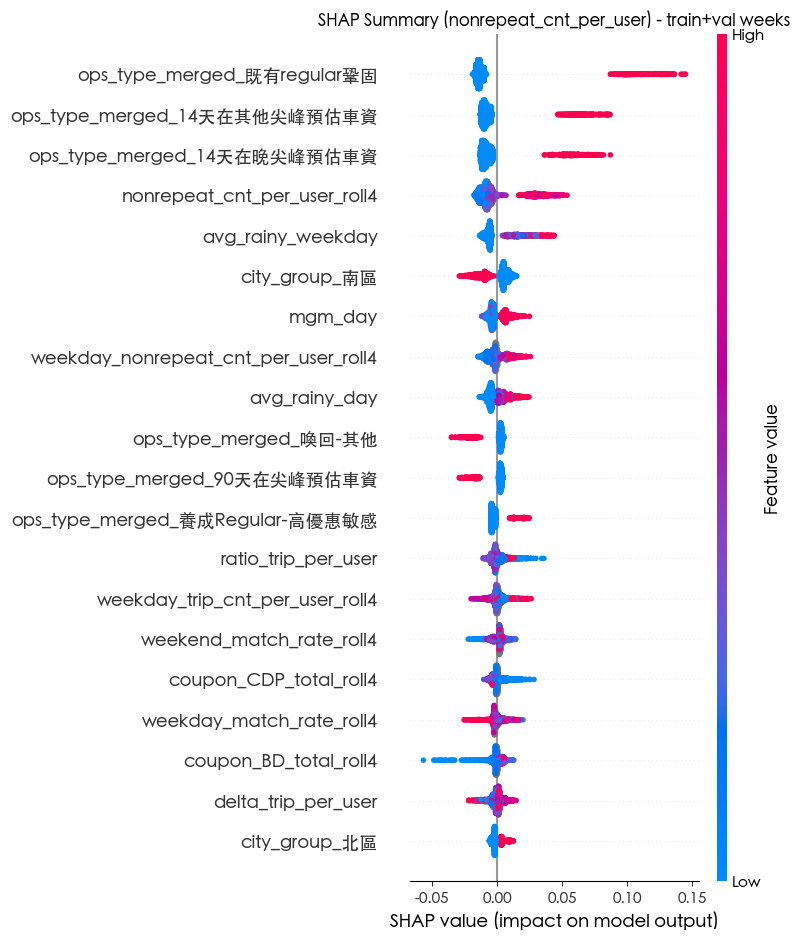

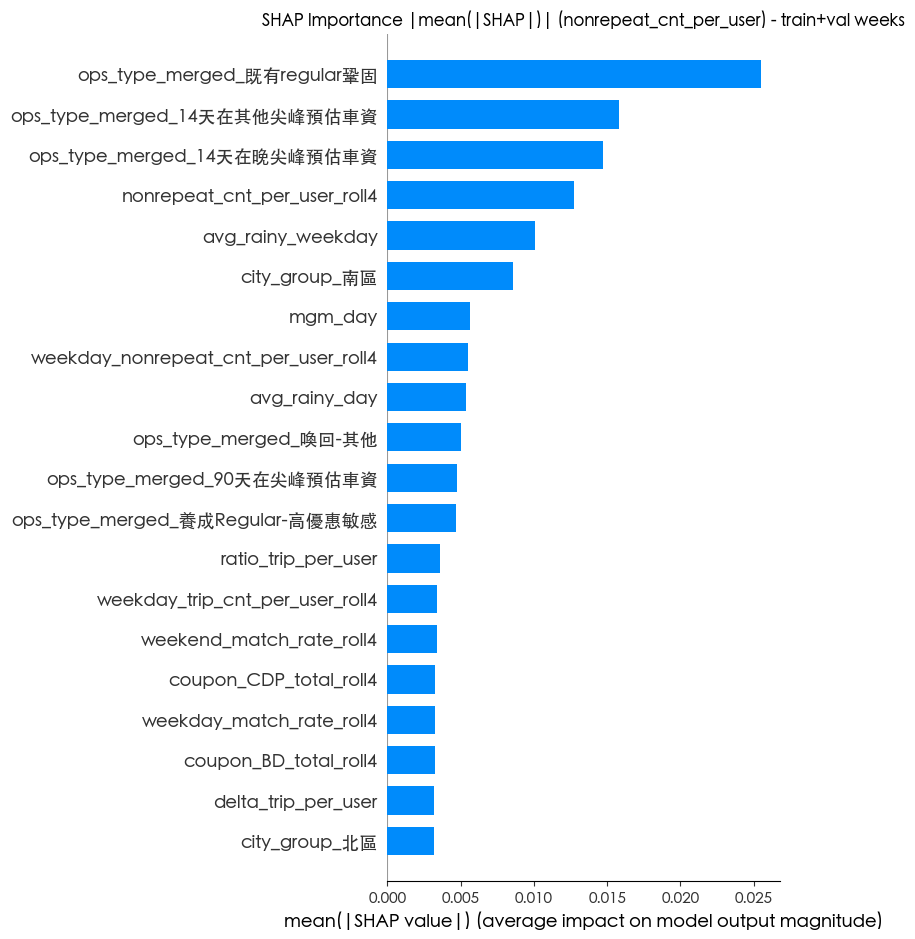

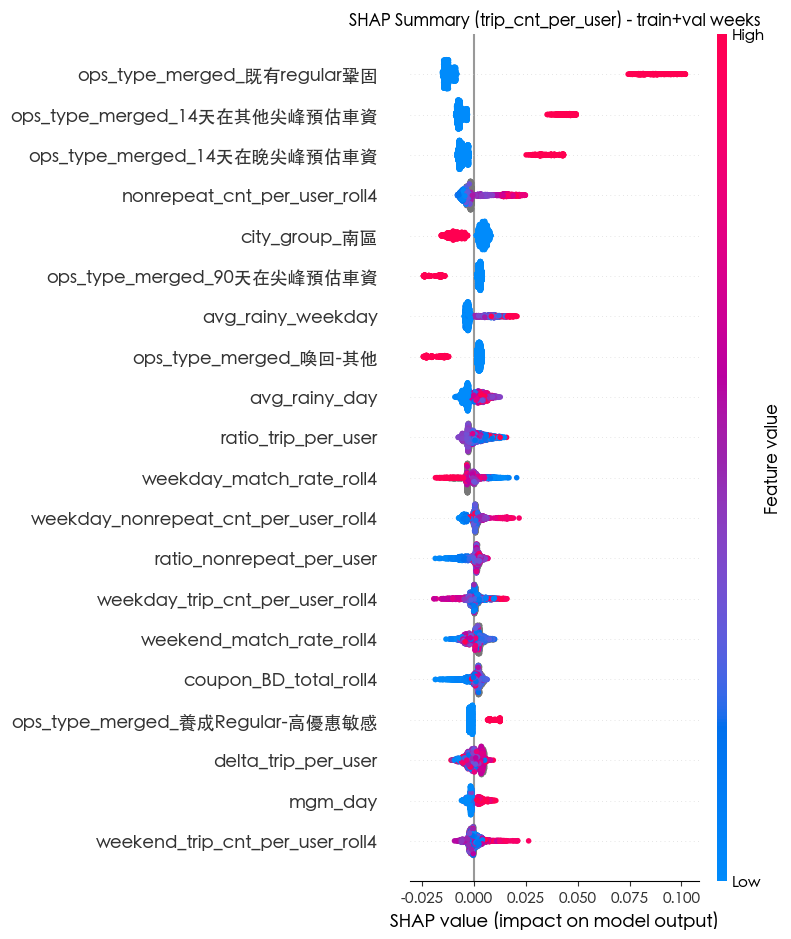

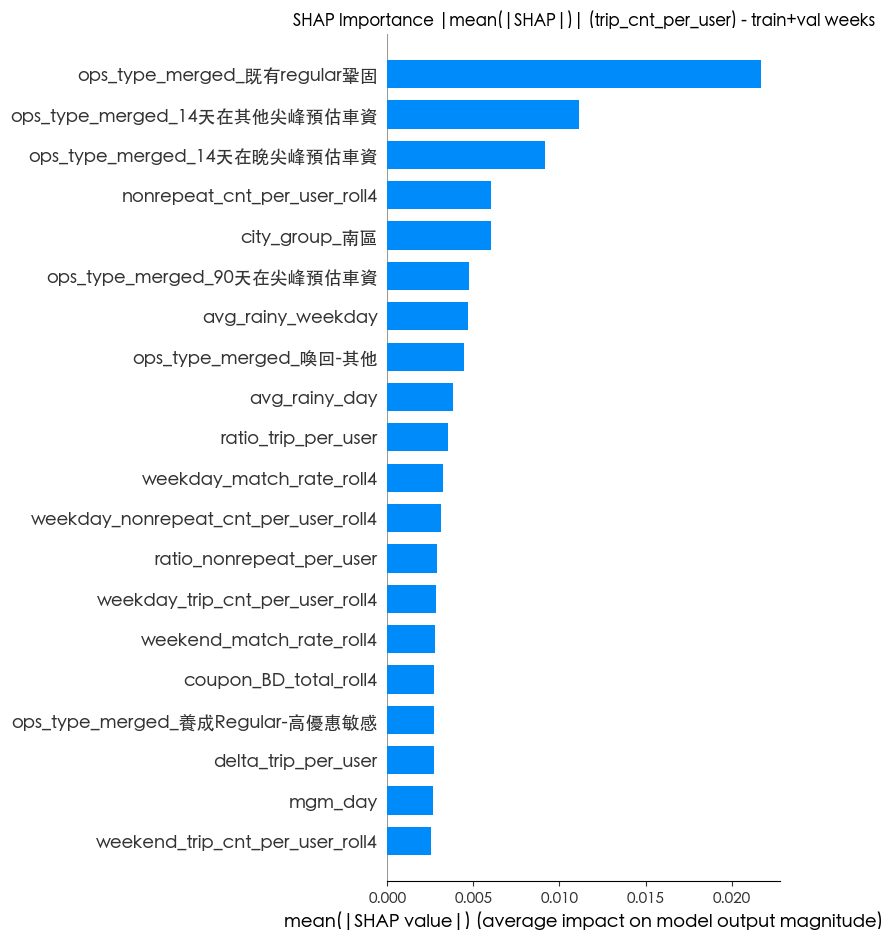

<Figure size 640x480 with 0 Axes>

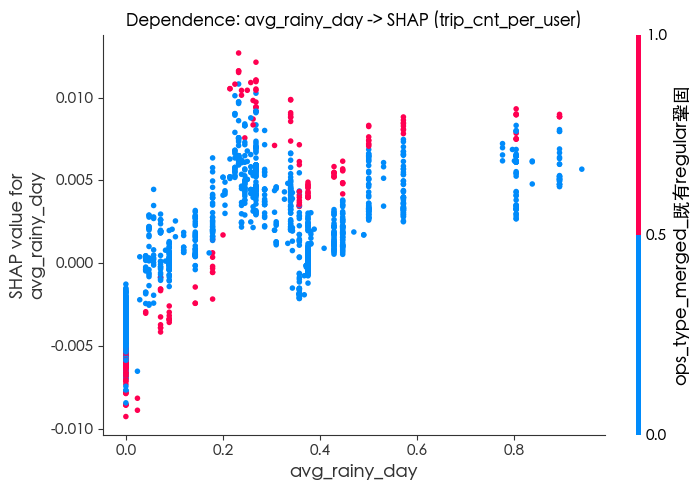

In [17]:
# ============================================================
# Optuna (train/val/test) + Retrain(train+val) + SHAP plots
# - 依照你提供的 Optuna 程式碼流程
# - 用 best_params 重訓後的模型來算 SHAP（train+val 上抽樣）
# ============================================================

import pandas as pd
import numpy as np

import optuna
from optuna.samplers import TPESampler

import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

import shap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# =========================
# Utils
# =========================
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def find_roll4_col(df, target_name: str):
    cols = list(df.columns)
    lower = {c: c.lower() for c in cols}

    exact = []
    for c in cols:
        cl = lower[c]
        if cl == f"roll4_{target_name}".lower() or cl == f"{target_name}_roll4".lower():
            exact.append(c)
    if len(exact) == 1:
        return exact[0]
    if len(exact) > 1:
        raise ValueError(f"Multiple exact roll4 columns found for {target_name}: {exact}")

    cand = [c for c in cols if ("roll4" in lower[c]) and (target_name.lower() in lower[c])]
    if len(cand) == 1:
        return cand[0]
    if len(cand) == 0:
        raise ValueError(f"No roll4 column found for target={target_name}.")
    raise ValueError(f"Multiple candidate roll4 columns found for {target_name}: {cand}")

def set_chinese_font():
    candidates = [
        "Noto Sans CJK TC", "Noto Sans CJK SC", "Noto Sans CJK JP",
        "PingFang TC", "Microsoft JhengHei", "Heiti TC",
        "WenQuanYi Zen Hei", "SimHei", "Arial Unicode MS",
    ]
    installed = {f.name for f in fm.fontManager.ttflist}
    for name in candidates:
        if name in installed:
            plt.rcParams["font.family"] = name
            break
    plt.rcParams["axes.unicode_minus"] = False

def fit_best(best_params: dict, X_tr, y_tr):
    if not isinstance(best_params, dict):
        raise TypeError(f"best_params must be dict, got {type(best_params)}: {best_params}")

    final_params = {
        "n_estimators": 20000,
        "random_state": 42,
        "n_jobs": -1,
        "verbose": -1,
        **best_params,
    }
    model = LGBMRegressor(**final_params)
    model.fit(X_tr, y_tr)
    return model

# =========================
# 0) Settings
# =========================
set_chinese_font()

path = "../../final_data/data_260125_random.csv"
TEST_WEEK = pd.Timestamp("2026-01-05")
VAL_WEEKS = 4
N_TRIALS = 600

# SHAP 若太慢：改小或設 None(全量)
SHAP_SAMPLE_N = 20000

# =========================
# 1) Load
# =========================
df = pd.read_csv(path)
df["experiment_date"] = pd.to_datetime(df["experiment_date"])

# =========================
# 2) Define columns
# =========================
id_cols = ["experiment_date", "treatment", "source", "ops_type_merged", "city_group"]
target_cols = ["nonrepeat_cnt_per_user", "trip_cnt_per_user"]

base_cols = [
    "face_value",
    "face_value_num",
    "avg_rainy_day",
    "avg_rainy_weekday",
    "avg_rainy_weekend",
    "mgm_day",
    "delta_trip_per_user",
    "delta_nonrepeat_per_user",
    "ratio_trip_per_user",
    "ratio_nonrepeat_per_user",
]

roll4_cols = [c for c in df.columns if "roll4" in c.lower()]
cat_extra = ["treatment", "source", "ops_type_merged", "city_group"]

feature_cols = base_cols + roll4_cols + cat_extra
need_cols = ["experiment_date"] + target_cols + feature_cols

missing = [c for c in need_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

# =========================
# 3) Split: train / val / test (time-based)
# =========================
all_weeks = (
    df.loc[df["experiment_date"] < TEST_WEEK, "experiment_date"]
      .dropna()
      .drop_duplicates()
      .sort_values()
      .to_list()
)
if len(all_weeks) < VAL_WEEKS:
    raise ValueError(f"Not enough weeks before TEST_WEEK to make {VAL_WEEKS} validation weeks.")

val_weeks = set(all_weeks[-VAL_WEEKS:])
train_weeks = set(all_weeks[:-VAL_WEEKS])

train_df = df.loc[df["experiment_date"].isin(train_weeks), need_cols].copy()
val_df   = df.loc[df["experiment_date"].isin(val_weeks), need_cols].copy()
test_df  = df.loc[df["experiment_date"] == TEST_WEEK, need_cols].copy()

if len(test_df) == 0:
    raise ValueError(f"No rows found for experiment_date == {TEST_WEEK.date()}")

print("VAL weeks:", sorted(list(val_weeks)))
print("Train rows:", len(train_df), "Val rows:", len(val_df), "Test rows:", len(test_df))

# =========================
# 4) Build X / y  + one-hot categorical + align
# =========================
X_train = train_df[feature_cols].copy()
X_val   = val_df[feature_cols].copy()
X_test  = test_df[feature_cols].copy()

y_train_nonrepeat = train_df["nonrepeat_cnt_per_user"].astype(float)
y_val_nonrepeat   = val_df["nonrepeat_cnt_per_user"].astype(float)
y_test_nonrepeat  = test_df["nonrepeat_cnt_per_user"].astype(float)

y_train_trip = train_df["trip_cnt_per_user"].astype(float)
y_val_trip   = val_df["trip_cnt_per_user"].astype(float)
y_test_trip  = test_df["trip_cnt_per_user"].astype(float)

cat_cols = ["face_value"] + cat_extra
for X in (X_train, X_val, X_test):
    for c in cat_cols:
        X[c] = X[c].astype("category")

X_train = pd.get_dummies(X_train, columns=cat_cols, dummy_na=True)
X_val   = pd.get_dummies(X_val,   columns=cat_cols, dummy_na=True)
X_test  = pd.get_dummies(X_test,  columns=cat_cols, dummy_na=True)

# 對齊欄位（dummy 欄位 train/val/test 可能不一致）
X_train, X_val  = X_train.align(X_val,  join="left", axis=1, fill_value=0)
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

# =========================
# 5) Optuna objective (tune on VAL RMSE)
# =========================
def make_objective(y_tr, y_va):
    def objective(trial: optuna.Trial):
        params = {
            # 固定
            "n_estimators": 20000,  # 讓 early stopping 決定 best iteration
            "random_state": 42,
            "n_jobs": -1,
            "verbose": -1,

            # 調參範圍
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.08, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 15, 255, log=True),
            "max_depth": trial.suggest_int("max_depth", -1, 16),
            "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
            "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
        }

        model = LGBMRegressor(**params)
        model.fit(
            X_train, y_tr,
            eval_set=[(X_val, y_va)],
            eval_metric="rmse",
            callbacks=[
                lgb.early_stopping(stopping_rounds=200, verbose=False),
                lgb.log_evaluation(period=0),
            ],
        )

        pred_val = model.predict(X_val)
        return rmse(y_va, pred_val)

    return objective

# =========================
# 6) Run studies (one per target)
# =========================
sampler = TPESampler(seed=42)

# nonrepeat
study_nonrepeat = optuna.create_study(direction="minimize", sampler=sampler)
study_nonrepeat.optimize(make_objective(y_train_nonrepeat, y_val_nonrepeat), n_trials=N_TRIALS)

print("\n[Best nonrepeat]")
print("val_rmse:", study_nonrepeat.best_value)
print("params:", study_nonrepeat.best_params)

# trip
study_trip = optuna.create_study(direction="minimize", sampler=sampler)
study_trip.optimize(make_objective(y_train_trip, y_val_trip), n_trials=N_TRIALS)

print("\n[Best trip]")
print("val_rmse:", study_trip.best_value)
print("params:", study_trip.best_params)

best_params_nonrepeat = study_nonrepeat.best_params
best_params_trip      = study_trip.best_params

# =========================
# 7) Retrain on train+val with best params, then test on 2026-01-05
# =========================
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval_nonrepeat = pd.concat([y_train_nonrepeat, y_val_nonrepeat], axis=0)
y_trainval_trip      = pd.concat([y_train_trip,      y_val_trip], axis=0)

m_nonrepeat = fit_best(best_params_nonrepeat, X_trainval, y_trainval_nonrepeat)
m_trip      = fit_best(best_params_trip,      X_trainval, y_trainval_trip)

pred_nonrepeat = m_nonrepeat.predict(X_test)
pred_trip      = m_trip.predict(X_test)

print("\n[Test RMSE on 2026-01-05]")
print("RMSE (nonrepeat):", rmse(y_test_nonrepeat, pred_nonrepeat))
print("RMSE (trip)     :", rmse(y_test_trip, pred_trip))

# =========================
# 8) (Optional) Compare roll4 baseline on same test week
# =========================
col_roll4_nonrepeat = find_roll4_col(df, "nonrepeat_cnt_per_user")
col_roll4_trip      = find_roll4_col(df, "trip_cnt_per_user")

baseline_nonrepeat = test_df[col_roll4_nonrepeat].astype(float).values
baseline_trip      = test_df[col_roll4_trip].astype(float).values

print("\n[Roll4 baseline RMSE on 2026-01-05]")
print("baseline RMSE (nonrepeat):", rmse(y_test_nonrepeat, baseline_nonrepeat))
print("baseline RMSE (trip)     :", rmse(y_test_trip, baseline_trip))

# =========================
# 9) SHAP: choose sample set (train+val)
# =========================
if SHAP_SAMPLE_N is None or SHAP_SAMPLE_N >= len(X_trainval):
    X_shap = X_trainval
else:
    X_shap = X_trainval.sample(SHAP_SAMPLE_N, random_state=42)

# TreeExplainer: for tree model
expl_nonrepeat = shap.TreeExplainer(m_nonrepeat)
expl_trip      = shap.TreeExplainer(m_trip)

shap_values_nonrepeat = expl_nonrepeat.shap_values(X_shap)
shap_values_trip      = expl_trip.shap_values(X_shap)

# =========================
# 10) Plot SHAP: summary(beeswarm) + bar
# =========================
# nonrepeat
plt.figure()
shap.summary_plot(shap_values_nonrepeat, X_shap, show=False)
plt.title("SHAP Summary (nonrepeat_cnt_per_user) - train+val weeks")
plt.tight_layout()
plt.show()

plt.figure()
shap.summary_plot(shap_values_nonrepeat, X_shap, plot_type="bar", show=False)
plt.title("SHAP Importance |mean(|SHAP|)| (nonrepeat_cnt_per_user) - train+val weeks")
plt.tight_layout()
plt.show()

# trip
plt.figure()
shap.summary_plot(shap_values_trip, X_shap, show=False)
plt.title("SHAP Summary (trip_cnt_per_user) - train+val weeks")
plt.tight_layout()
plt.show()

plt.figure()
shap.summary_plot(shap_values_trip, X_shap, plot_type="bar", show=False)
plt.title("SHAP Importance |mean(|SHAP|)| (trip_cnt_per_user) - train+val weeks")
plt.tight_layout()
plt.show()

# =========================
# 11) (Optional) Dependence plot example
# =========================
feat = "avg_rainy_day"
if feat in X_shap.columns:
    plt.figure()
    shap.dependence_plot(feat, shap_values_trip, X_shap, show=False)
    plt.title(f"Dependence: {feat} -> SHAP (trip_cnt_per_user)")
    plt.tight_layout()
    plt.show()

# （需要就存）
# eval_df.to_csv("../../final_data/pred_eval_2026-01-05_optuna_with_cats.csv", index=False, encoding="utf-8-sig")
